In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
POS_PATH= os.path.join('data', 'positive')
NEG_PATH= os.path.join('data', 'negative')
ANC_PATH= os.path.join('data', 'anchor')

In [3]:
# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

In [4]:
#uncompressing tar file

# !tar -xf lfw.tgz

In [5]:
#moving the lfw images to the negative folder


# for directory in os.listdir('lfw'):
#   for file in os.listdir(os.path.join('lfw', directory)):
#     EX_PATH= os.path.join('lfw', directory, file) #existing path
#     NEW_PATH= os.path.join(NEG_PATH, file)
#     os.replace(EX_PATH, NEW_PATH)

In [6]:
#importing uuid library to generate unique image names
import uuid

os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\3b59672d-8365-11ed-90fa-54bf6418a3f5.jpg'

In [7]:
# # #Collecting data for positive and anchor classes

# cap= cv2.VideoCapture(0)

# while cap.isOpened():
#   ret,frame= cap.read() #frame is the actual image

#   frame = frame[100:250+100, 200:200+250, :] #making the image 250X250 px
    

#   #collect anchors
#   if cv2.waitKey(1) & 0XFF== ord('a'):
#         imgname= os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())) #creating unique file path
#         cv2.imwrite(imgname, frame) #writing down image
        
        
#   #collect positives
#   if cv2.waitKey(1) & 0XFF== ord('p'):
#         imgname= os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())) 
#         cv2.imwrite(imgname, frame)

#   cv2.imshow('Image Collection', frame) #show image to the screen

#   if cv2.waitKey(1) & 0XFF== ord('q'):
#     break

# cap.release() #Releasing webcamqq
# cv2.destroyAllWindows()


In [8]:
# frame.shape #as the shape is not in the 250,250 range we will make some adjustments

## 3. Loading and Preprocessing Images

### 3.1 Get image directories

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D, Dense, Flatten, Input

In [10]:
#Data Augmentation

def data_aug(img):
    data=[]
    
    for i in range(9):
        
        img= tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img= tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        img= tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100), np.random.randint(100)))
        img= tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100), np.random.randint(100)))
        img= tf.image.stateless_random_saturation(img, lower=0.9, upper=1, seed=(np.random.randint(100), np.random.randint(100)))
        
        data.append(img)
        
    return data
    

In [11]:
# for file_name in os.listdir(os.path.join(ANC_PATH)):
#     img_path= os.path.join(ANC_PATH, file_name)
#     img= cv2.imread(img_path)
#     augmented_images= data_aug(img)
    
#     for image in augmented_images:
#         cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [12]:
#using tf.data.Datasets to make data input pipelines

anchor= tf.data.Dataset.list_files(ANC_PATH+ '\*.jpg').take(3000) #\* indidcating to grab everything in the jpg format
positive= tf.data.Dataset.list_files(POS_PATH+ '\*.jpg').take(3000)
negative= tf.data.Dataset.list_files(NEG_PATH+ '\*.jpg').take(3000)

In [13]:
#checking
dir_test= anchor.as_numpy_iterator()
ex= dir_test.next()
print(ex)


b'data\\anchor\\7513191d-82c4-11ed-9a9f-54bf6418a3f5.jpg'


### 3.2 Preprocessing- Scaling and Resize

In [14]:
def preprocessing(file_path):
    
    byte_img= tf.io.read_file(file_path)
    img= tf.io.decode_jpeg(byte_img)
    img= tf.image.resize(img, (100,100))
    img= img/255.0
    return img

In [15]:
a= preprocessing(ex)
a

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.3781863 , 0.38602942, 0.36642158],
        [0.38235295, 0.39411765, 0.3647059 ],
        [0.3781863 , 0.389951  , 0.35465688],
        ...,
        [0.4759804 , 0.5661765 , 0.5367647 ],
        [0.47377452, 0.56397057, 0.54044116],
        [0.5019608 , 0.58431375, 0.5647059 ]],

       [[0.3877451 , 0.39558825, 0.3759804 ],
        [0.38308823, 0.39485294, 0.36544117],
        [0.3752451 , 0.3870098 , 0.35171568],
        ...,
        [0.45882353, 0.55196077, 0.5181373 ],
        [0.48039216, 0.5735294 , 0.54558825],
        [0.4875    , 0.56936276, 0.5480392 ]],

       [[0.3865196 , 0.39436275, 0.3747549 ],
        [0.39166668, 0.4034314 , 0.3740196 ],
        [0.3781863 , 0.389951  , 0.35465688],
        ...,
        [0.45661765, 0.5563725 , 0.51004905],
        [0.4622549 , 0.55539215, 0.51715684],
        [0.4882353 , 0.5656863 , 0.53333336]],

       ...,

       [[0.1637255 , 0.21176471, 0.24411765],
        [0.16

In [16]:
a.numpy().max()

0.86519605

In [17]:
len(anchor)

3000

### 3.3 Creating Labelled dataset

In [18]:
positives= tf.data.Dataset.zip((anchor,positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives= tf.data.Dataset.zip((anchor,negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data= positives.concatenate(negatives)

In [19]:
example= data.as_numpy_iterator().next()
print(example)

(b'data\\anchor\\28bef3ca-82c4-11ed-a131-54bf6418a3f5.jpg', b'data\\positive\\293ad19d-82a2-11ed-a2a8-54bf6418a3f5.jpg', 1.0)


### 3.4 Building train test partition

In [20]:
def process(test_img, val_img, label):
    return (preprocessing(test_img), preprocessing(val_img), label)

In [21]:
process(*example)

(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
 array([[[0.51911765, 0.5857843 , 0.54656863],
         [0.50514704, 0.5718137 , 0.532598  ],
         [0.50980395, 0.5764706 , 0.5372549 ],
         ...,
         [0.39313725, 0.40490195, 0.37745097],
         [0.39828432, 0.41004902, 0.38259804],
         [0.4       , 0.4117647 , 0.38431373]],
 
        [[0.5088235 , 0.5735294 , 0.54313725],
         [0.49436274, 0.56102943, 0.52818626],
         [0.5019608 , 0.56715685, 0.53063726],
         ...,
         [0.39019608, 0.4019608 , 0.3745098 ],
         [0.4019608 , 0.4137255 , 0.38627452],
         [0.40392157, 0.41568628, 0.3882353 ]],
 
        [[0.5120098 , 0.5708333 , 0.5492647 ],
         [0.5002451 , 0.56691176, 0.5355392 ],
         [0.49509802, 0.55588233, 0.527451  ],
         ...,
         [0.39387256, 0.40563726, 0.3781863 ],
         [0.39607844, 0.40784314, 0.38039216],
         [0.39607844, 0.40784314, 0.38039216]],
 
        ...,
 
        [[0.16764706, 0.20686275

In [22]:
#building dataloader pipeline

data= data.map(process)
data= data.cache()
data= data.shuffle(buffer_size=10000)

In [23]:
data

<ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [24]:
a= data.as_numpy_iterator()
samp= a.next()

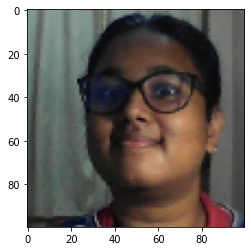

In [25]:
plt.imshow(samp[1])

In [26]:
#creating train partition

train_data= data.take(round(len(data) *.7))
train_data= train_data.batch(16)
train_data= train_data.prefetch(8)


In [27]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [28]:
#checking 
ts= train_data.as_numpy_iterator()
tss= ts.next()

len(tss[1])

16

In [29]:
#creating testing partition

test_data= data.skip(round(len(data) *.7))
test_data= test_data.take(round(len(data) * .3))
test_data= test_data.batch(16)
test_data= test_data.prefetch(8)

## 4. Model

### 4.1 Embedding layer

In [30]:
def make_embedding():
    
    inp= Input(shape= (100,100,3), name='input_image')
    
    #first block
    c1= Conv2D(64, (10,10), activation= 'relu')(inp)
    m1= MaxPooling2D(64, (2,2), padding='same')(c1)
    
    #second block
    c2= Conv2D(128, (7,7), activation= 'relu')(m1)
    m2= MaxPooling2D(64, (2,2), padding='same')(c2)
    
    #third block
    c3= Conv2D(128, (4,4), activation= 'relu')(m2)
    m3= MaxPooling2D(64, (2,2), padding='same')(c3)
    
    #final embedding block
    c4= Conv2D(256, (4,4), activation='relu')(m3)
    f1= Flatten()(c4)
    d1= Dense(4096, activation= 'sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1] , name='embedding')
    

In [31]:
embedding= make_embedding()

In [32]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

### 4.2 Build Distance layer

The output that we are going to get through 2 streams, we are subtracting them to make one common output which will help us to do the facial recognition by basically telling us how similar these layers are

In [33]:
#siamese L1 distance class

class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
        
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

### 4.3 Make Siamese Model

In [34]:
def make_siamese_model():
    
    #anchor image input in the network
    input_image= Input(name='input_img', shape=(100,100,3))
    
    #validation image in the network
    validation_image= Input(name='validation_img', shape= (100,100,3))
    
    #combining siamese distance components
    siamese_layer= L1Dist()
    siamese_layer._name= 'distance'
    distances= siamese_layer(embedding(input_image), embedding(validation_image))
    
    #classification layer
    classifier= Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs= [input_image, validation_image], outputs= classifier, name='SiameseNetwork')
    

In [35]:
siamese_model= make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

 ## 5. Training
 
 ### 5.1 Setup Losses and Optimisers

In [36]:
binary_cross_loss= tf.losses.BinaryCrossentropy()

In [37]:
opt= tf.optimizers.Adam(1e-4)

### 5.2 Establishing Checkpoints

In [38]:
checkpoint_dir= './training_checkpoints'
checkpoint_prefix= os.path.join(checkpoint_dir, 'ckpt')
checkpoint= tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

### 5.3 Building Train step function

In [39]:
test_batch= train_data.as_numpy_iterator()
ts1= test_batch.next()

In [40]:
np.array(ts1[:2]).shape

(2, 16, 100, 100, 3)

In [41]:
#building function

@tf.function
def train_step(batch):
    
    with tf.GradientTape() as tape: #used for the calculating differentials and for backpropagation
        
        #Get aanchor and positive/negative image
        X=batch[:2]
        
        #label
        y=batch[2]
        
        #forward pass
        yhat= siamese_model(X, training=True)
        
        #Calculating loss
        loss= binary_cross_loss(y, yhat)
    
    print(loss)
    
    #calculate gradients
    grad= tape.gradient(loss, siamese_model.trainable_variables)
    
    #calculate updated weights and apply to the siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    return loss
    
    

In [42]:
#training loop

def train(data, EPOCHS):
    #loop through Epochs
    
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar= tf.keras.utils.Progbar(len(data))
        
        #creating metric object
        r=Recall()
        p=Precision()
        
       #loop through each batch
        for idx , batch in enumerate(data):
            loss= train_step(batch)
            yhat= siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
    
        #save checkpoints
        if epoch % 10==0:
            checkpoint.save(file_prefix= checkpoint_prefix)
        

## 8. Real time Test

In [43]:
#Loading the trained model

model= tf.keras.models.load_model('siamesemodelv2.h5',
                                custom_objects= {'L1Dist': L1Dist, 'BinaryCrossentropy': tf.losses.BinaryCrossentropy})




In [44]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

### 8.1 Verification Function

In [45]:
def verify( model, detection_threshold, verification_threshold):
    
    #detection threshold: Metric above which a prediction is considered positive
    #verification threshold: proprtion of positive predictions / total positive samples
    
    results= []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img= preprocessing(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img=  preprocessing(os.path.join('application_data', 'verification_images', image))
        
        result= model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    
    detection= np.sum(np.array(results)> detection_threshold)
    verification= detection/ len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified= verification > verification_threshold #returns boolean
    
    return results, verified

In [46]:
### 8.2 OpenCV Real time verification

cap= cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame= cap.read()
    
    frame =frame[190:190+250, 250:250+250, :] 
    
    cv2.imshow('Verification', frame)
    
    #verification trigger
    if cv2.waitKey(1) & 0xFF== ord('v'):
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        
        results, verified= verify(model,0.5,0.5)
        print(verified)
    
    if cv2.waitKey(1) & 0xFF== ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()
        
    
    

1/1 [==============================] - 0s 225ms/step
True
